In [1]:
import pandas as pd
import numpy as np
import requests
import json
import re
import time

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

from api_keys import GOOGLE_API_KEY
from csv_pkl_sql import save_it, pkl_it

pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
%matplotlib inline

# Get latitude and longitude for locations

In [9]:
location_key = pd.read_pickle('../pkl/00_cleaned_city_names.pkl')

location_key.shape[0]

1606

In [4]:
location_key.head(2)

,location,location_type,country,province,county,city
0,Argentina-Buenos_Aires,province,Argentina,Buenos Aires,None,None
1,Argentina-CABA,province,Argentina,Ciudad de Buenos Aires,None,None


## First try Google Maps API

In [115]:
def get_latitude_longitude(df_row):
    subtype = df_row.location_type
    second_str = df_row[subtype].replace(' ', '+')
    country_str = df_row.country.replace(' ', '+')
    
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=+{},+{}&key={}'.format(second_str, 
                                                                                            country_str, 
                                                                                            GOOGLE_API_KEY)
    
    try:
        response = requests.get(url).text
        lat_lng = json.loads(response)['results'][0]['geometry']['location']
        lat_lng_df = pd.Series({'lat':lat_lng['lat'], 'lng':lat_lng['lng']})
    except:
        lat_lng_df = pd.Series({'lat':np.NaN, 'lng':np.NaN})
        
    time.sleep(1)
    return lat_lng_df

In [ ]:
location_key[['latitude','longitude']] = location_key.apply(lambda x: get_latitude_longitude(x), axis=1)

## Then scrape Google's first search hit
We tried to play nice. Now bring out the big guns for the non-matches.

In [ ]:
def google_search_scrape(df_row, driver_list=driver_list):
    
    # If both are floats, it's because they're NaNs--thus we need to scrape
    if isinstance(df_row.latitude_s, float) & isinstance(df_row.longitude_s, float):
    
        # Randomized driver selected from a list where each is running through
        # different ports
        driver = np.random.choice(driver_list)

        subtype = df_row.location_type
        second_str = df_row[subtype].replace(' ', '+')
        country_str = df_row.country.replace(' ', '+')
        total_str = country_str + '+' + second_str

        url = 'https://www.google.com/search?client=safari&rls=en&q={}&ie=UTF-8&oe=UTF-8#q={}+latitude+longitude'.format(total_str, total_str)
        try:
            driver.get(url)
            time.sleep(3)
            text = driver.find_element_by_class_name('kp-header').text
            time.sleep(5)
            text_array = re.split(r""", """, text)
        except:
            print(total_str)
            text_array = [np.NaN, np.NaN]
            
    else:
        # Alread have this data so return existing values
        text_array = [df_row.latitude_s, df_row.longitude_s]
        
    return pd.Series({'latitude_s':text_array[0], 'longitude_s':text_array[1]})

In [ ]:
location_key_scrape = location_key[(location_key.latitude.isnull()|location_key.longitude.isnull())]
location_key_scrape['latitude_s'] = ''
location_key_scrape['longitude_s'] = ''

In [ ]:
# location_key_scrape[['latitude_s','longitude_s']] = (scrape_results.loc[scrape_results!='']
#                                                      .str.split(r""", """, expand=True)
#                                                      )

In [ ]:
# ssh -ND 8081 nestanmr
# ssh -ND 8082 backupsy
# ssh -ND 8083 aws
# ssh -ND 8084 vultr

port_list = [8081, 8082, 8083, 8084]

chrome_options1 = Options().add_argument("--proxy-server=socks5://127.0.0.1:" + str(port_list[0]))
chrome_options2 = Options().add_argument("--proxy-server=socks5://127.0.0.1:" + str(port_list[1]))
chrome_options3 = Options().add_argument("--proxy-server=socks5://127.0.0.1:" + str(port_list[2]))
chrome_options4 = Options().add_argument("--proxy-server=socks5://127.0.0.1:" + str(port_list[3]))

driver1 = webdriver.Chrome('/Volumes/Files/homebrew/bin/chromedriver', chrome_options=chrome_options1)
driver2 = webdriver.Chrome('/Volumes/Files/homebrew/bin/chromedriver', chrome_options=chrome_options2)
driver3 = webdriver.Chrome('/Volumes/Files/homebrew/bin/chromedriver', chrome_options=chrome_options3)
driver4 = webdriver.Chrome('/Volumes/Files/homebrew/bin/chromedriver', chrome_options=chrome_options4)

driver_list = [driver1, driver2, driver3, driver4]
location_key_scrape[['latitude_s','longitude_s']] = location_key_scrape.apply(lambda x: google_search_scrape(x, driver_list), axis=1)

In [ ]:
# Save a temporary checkpoint of this dataframe
pkl_it(location_key_scrape, '01_latitude_longitude_checkpoint_location_key_scrape')
pkl_it(location_key, '01_latitude_longitude_checkpoint_location_key')

In [ ]:
# Convert the latitude and longitude strings to floats

location_key_scrape['latitude_s'] = location_key_scrape.latitude_s.str.strip()
location_key_scrape['longitude_s'] = location_key_scrape.longitude_s.str.strip()

location_key_scrape['latitude'] = (location_key_scrape.latitude_s
                                   .str.extract(r"""([0-9.-]+)""")
                                   .astype(float))

location_key_scrape['longitude'] = (location_key_scrape.longitude_s
                                    .str.extract(r"""([0-9.-]+)""")
                                    .astype(float))

mask = (location_key_scrape.latitude_s.str[-1]=='S')
location_key_scrape.loc[mask, 'latitude'] *= -1.0

mask = (location_key_scrape.longitude_s.str[-1]=='W')
location_key_scrape.loc[mask, 'longitude'] *= -1.0

In [ ]:
# Transfer the scraped data back to the main dataframe
location_key.loc[location_key_scrape.index, 'latitude'] = location_key_scrape.latitude
location_key.loc[location_key_scrape.index, 'longitude'] = location_key_scrape.longitude

In [ ]:
pkl_it(location_key, '01_latitude_longitude_checkpoint_location_key_2')

## Now scrape [www.latlong.net](http://www.latlong.net/)

There are 104 locations left without a match. A few of these can be done manually (e.g. the United States locations), but let's try to get a few more with scraping.

**NOTE:** for future reference, [distancesto.com](https://www.distancesto.com) looks like it could be scraped.

In [ ]:
def scrape_latlong(the_location, driver_list=driver_list):
    
    driver = np.random.choice(driver_list)
    
    try:
        # Load the web page
        driver.get('http://www.latlong.net')
        time.sleep(1.0)

        # Enter the location
        text_field = driver.find_element_by_id('gadres')
        text_field.send_keys(the_location)
        time.sleep(1.0)

        # Click the find button
        the_button = driver.find_element_by_xpath('//*[@id="latlongform"]/button')
        the_button.click()
        time.sleep(1.5)

        # Scrape the latitude and longitude
        lat_long_str = driver.find_element_by_xpath('//*[@id="latlngspan"]').text
        lat_long_re = re.search(r"""\(([0-9.-]+),\s*([0-9.-]+)\)""", lat_long_str)
        latitude = float(lat_long_re.group(1))
        longitude = float(lat_long_re.group(2))
    except:
        latitude = np.NaN
        longitude = np.NaN

    return pd.Series({'latitude':latitude, 'longitude':longitude})

In [ ]:
# Separate just the null records to scrape
location_key_scrape = location_key.loc[location_key.latitude.isnull()].copy()

In [ ]:
# ssh -ND 8081 nestanmr
# ssh -ND 8082 backupsy
# ssh -ND 8083 aws
# ssh -ND 8084 vultr

port_list = [8081, 8082, 8083, 8084]

chrome_options1 = Options().add_argument("--proxy-server=socks5://127.0.0.1:" + str(port_list[0]))
chrome_options2 = Options().add_argument("--proxy-server=socks5://127.0.0.1:" + str(port_list[1]))
chrome_options3 = Options().add_argument("--proxy-server=socks5://127.0.0.1:" + str(port_list[2]))
chrome_options4 = Options().add_argument("--proxy-server=socks5://127.0.0.1:" + str(port_list[3]))

driver1 = webdriver.Chrome('/Volumes/Files/homebrew/bin/chromedriver', chrome_options=chrome_options1)
driver2 = webdriver.Chrome('/Volumes/Files/homebrew/bin/chromedriver', chrome_options=chrome_options2)
driver3 = webdriver.Chrome('/Volumes/Files/homebrew/bin/chromedriver', chrome_options=chrome_options3)
driver4 = webdriver.Chrome('/Volumes/Files/homebrew/bin/chromedriver', chrome_options=chrome_options4)

driver_list = [driver1, driver2, driver3, driver4]

location_key_scrape[['latitude','longitude']] = (location_key_scrape
                                                 .apply(lambda x: scrape_latlong(x.location, driver_list), 
                                                        axis=1)
                                                 )

In [ ]:
location_key_scrape.loc[location_key_scrape.latitude.isnull()]

In [ ]:
# Save temporary checkpoints
pkl_it(location_key_scrape, '01_latitude_longitude_checkpoint_location_key_scrape_2')
pkl_it(location_key, '01_latitude_longitude_checkpoint_location_key_2')

In [ ]:
# Transfer the scraped data back to the main dataframe
location_key.loc[location_key_scrape.index, 'latitude'] = location_key_scrape.latitude
location_key.loc[location_key_scrape.index, 'longitude'] = location_key_scrape.longitude

In [ ]:
location_key.loc[location_key.latitude.isnull()]

In [ ]:
# Fill in the remaining ones manually
mask = location_key.location == 'Colombia-Norte_Santander-La_Playa'
location_key.loc[mask, ['latitude', 'longitude']] = [7.946283, -72.898807]

mask = location_key.location == 'Colombia-Desconocido-Desconocido'
location_key.loc[mask, ['latitude', 'longitude']] = [np.NaN , np.NaN]

mask = location_key.location == 'Colombia-Bogota-Bosa_Tintal_Sur'
location_key.loc[mask, ['latitude', 'longitude']] = [ 4.624335, -74.063644]

mask = location_key.location == 'Dominican_Republic-Extranjera'
location_key.loc[mask, ['latitude', 'longitude']] = [18.735693 , -70.16265099999998]

mask = location_key.location == 'Dominican_Republic-Other'
location_key.loc[mask, ['latitude', 'longitude']] = [18.735693 , -70.16265099999998]

mask = location_key.location == 'Nicaragua-Other'
location_key.loc[mask, ['latitude', 'longitude']] = [12.865416, -85.20722899999998]

mask = location_key.location == 'Panama-Kuna_Yala-Acuatupu'
location_key.loc[mask, ['latitude', 'longitude']] = [9.234439, -78.192625]

mask = location_key.location == 'Panama-San_Miguelito-San_Jose'
location_key.loc[mask, ['latitude', 'longitude']] = [9.070755, -79.481638]

In [ ]:
# Prune unwanted columns
location_key_out = location_key[['location','latitude','longitude']]

In [ ]:
location_key_out.latitude.shape[0], location_key_out.latitude.isnull().sum()

In [ ]:
# Save unmatched entries to a CSV
location_key_out.loc[location_key_out.latitude.isnull()].to_csv('../csv/01_latitude_longitude_unmatched.csv')

In [119]:
location_key_out.latitude.min(), location_key_out.latitude.max()

(-54.805399800000004, 46.8797)

In [120]:
location_key_out.longitude.min(), location_key_out.longitude.max()

(-170.13220000000001, -36.781950500000001)

In [121]:
mask = ((location_key_out.longitude<-140)|(location_key_out.longitude>-20))
location_key_out.loc[mask]

,location,latitude,longitude
1634,United_States-American_Samoa,-14.2710,-170.1322
1644,United_States-Hawaii,19.8968,-155.5828


In [122]:
location_key_out.loc[1550, 'latitude'] = 8.5380
location_key_out.loc[1550, 'longitude'] = -80.7821

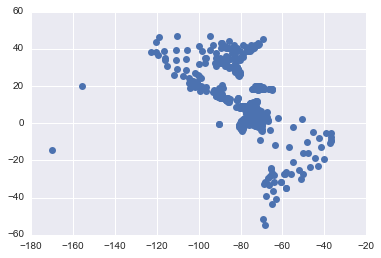

In [123]:
plt.plot(location_key_out.longitude, location_key_out.latitude, marker='o', ls='')

In [125]:
save_it(location_key_out, '01_latitude_longitude_google')